## Energy Resolution of Germanium detectors

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

NaI and Germanium detectors have wide fields of application for γ- and X-ray spectrometry thanks to their good energy resolution. The energy resolution of these detectors is defined as the width of the detected energy spectra peaks (FWHM); it depends on  
    - the statistics of the charge creation process  
    - the properties of the detector, and primarly its charge cllelction efficency   
    - the electronics noise  

The resolution can be expressed as the suquared sum of two terms:   
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$   
where the first term depends on teh detector properties as:  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$   
with $F$ the _Fano factor_,  
$E_{\gamma}$  the energy of the photon deposited energy(?)  
$w$ the electron hole-porduced energy threshold in germanium (w ~ 3eV).

The $w_e$ term in eq.1 is connected with the readout electronics and depends on the detector capacitance, the size of the detector and the bias voltage.

The following plot shows an uncalibrated energy spectrum collected with a Germanium detector
irradiated by a combination of three sources: 241Am, 60Co and 137Cs[2].

According to [2], the source nuclides emit the following photons:
Nuclide 241Am 137Cs 60Co
Photon energy (keV) 59.54 661.66 1173.24 1332.51
and these are the first four peaks (starting from the left side) visible in the figure. Similar spectra have
been collected with other gamma sources (i.e. Th-228).

Detailed Steps
##### 1. Understand the Data and Model

The energy resolution (FWHM) of the Germanium detectors is given by:  
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$


with  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$  


    ​

    Here, F is the Fano factor, $E_{\gamma}$​ is the energy of the photon, and w is the electron-hole production energy threshold in Germanium (approximately 3 eV).

    You need to determine w_d_​ and w_e_​ for your data.

##### 2. Define the Model for Fitting Peaks

Identify the function you will use to fit the peaks. A common choice for spectral peaks is the Gaussian function.
Define the full model incorporating the equation for FWHM and how it relates to the observed data.

Use a Gaussian function to model the peaks in the energy spectra:
$$f(E)=A * exp⁡(−\frac{(E−μ)^2}{2σ^2})$$
    
where μ is the peak center, σ is the standard deviation related to FWHM by $FWHM = 2 * \sqrt{2 * \log{2}} * \sigma$, and A is the amplitude.

##### 3. Set Up Bayesian Inference

Define prior distributions for the parameters μ, σ, A, $w_d$​, and $w_e$​. For example:  
$μ∼N(μ_0,(σ_{\mu})^2)$
$σ∼N(σ_0,σ_σ^2)$  
$A∼N(A_0,σ_A^2)$  
$w_d∼N(w_{d0},σ_{w_d}^2)$  
$w_e∼N(w_{e0},σ_{w_e}^2)$

where N denotes a normal distribution with specified mean and variance.

##### 4. Perform Bayesian Inference

Use a Bayesian inference library like Stan to perform Markov Chain Monte Carlo (MCMC) sampling to obtain the posterior distributions of the parameters.



##### 5. Validate and Interpret the Results

Check the trace plots and posterior distributions to ensure the MCMC chains have converged.
Compare the fitted model to the observed data using posterior predictive checks.

##### 6. Report the Results

Summarize the parameter estimates, including credible intervals.
Provide visualizations, such as trace plots and the fitted spectrum overlaid on the observed data.

### Theory Behind Bayesian Inference

Bayesian inference combines prior knowledge with observed data to update the probability of a hypothesis. The steps are:

- Prior Distribution: Represents your initial beliefs about the parameters before seeing the data.   
- Likelihood: Represents the probability of the observed data given the parameters.  
- Posterior Distribution: Updated beliefs about the parameters after considering the data, obtained via Bayes' theorem:  
    $P(θ∣data) ∝ P(data∣θ)P(θ)$


MCMC methods, such as the Metropolis-Hastings algorithm, are used to sample from the posterior distribution when it cannot be computed analytically.

Metropolis-Hastings: Proposes new parameter values and accepts them based on an acceptance criterion.


## 1. 
### Using statistical methods similar to that presented during the course, infere the FWHM of each γ peak for all available γ sources

### a. Load the required libraries

In [1]:
# Load the libraries
library(rstan)
library(ggplot2)
library(bayesplot)

library(dplyr)
library(nlstools)
library(pracma)

library(gridExtra)

# Configure rstan
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


Caricamento del pacchetto richiesto: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, u

### b. Load the data

I dati nei files rappresentano un tipico spettro energetico ottenuto da un rivelatore, in questo caso presumibilmente un rivelatore di germanio, dopo essere stato irradiato da una sorgente contenente Cesio-137 (Cs-137) (es). Ogni riga del file contiene due valori:

    Il primo valore rappresenta il canale del rivelatore, che è essenzialmente l'indice o la posizione del dato nel file.  
    Il secondo valore rappresenta il numero di conteggi (o eventi) registrati in quel canale durante la misura dell'energia.  

Canale del rivelatore:

    Ogni rivelatore di energia (come un rivelatore di germanio) divide l'intervallo di energia che può misurare in canali discreti. Ogni canale corrisponde a una determinata gamma di energia che il rivelatore è in grado di rilevare.

Conteggi:

    I conteggi registrati rappresentano il numero di volte che il rivelatore ha rilevato un evento energetico (un fotone gamma, nel caso di un rivelatore di germanio) in quel particolare canale durante l'esperimento.



In [2]:
# Load the data
gr11_co60 <- read.table("gr11_co60.txt", header = FALSE)
gr11_cs137 <- read.table("gr11_cs137.txt", header = FALSE)
gr11_na22 <- read.table("gr11_na22.txt", header = FALSE)
IC48A_AmCsCo <- read.table("IC48A_AmCsCo.txt", header = FALSE)
IC48A_Th <- read.table("IC48A_Th.txt", header = FALSE)

# Assign column names
colnames(gr11_co60) <- c("Channel", "Count")
colnames(gr11_cs137) <- c("Channel", "Count")
colnames(gr11_na22) <- c("Channel", "Count")
colnames(IC48A_AmCsCo) <- c("Channel", "Count")
colnames(IC48A_Th) <- c("Channel", "Count")

# Add the column log_Count
gr11_co60$log_Count <- log(gr11_co60$Count + 1)
gr11_cs137$log_Count <- log(gr11_cs137$Count + 1)
gr11_na22$log_Count <- log(gr11_na22$Count + 1)
IC48A_AmCsCo$log_Count <- log(IC48A_AmCsCo$Count + 1)
IC48A_Th$log_Count <- log(IC48A_Th$Count + 1)

# Drop the rows with Count < 0
gr11_co60 <- gr11_co60[gr11_co60$Count >= 0, ]
gr11_cs137 <- gr11_cs137[gr11_cs137$Count >= 0, ]
gr11_na22 <- gr11_na22[gr11_na22$Count >= 0, ]
IC48A_AmCsCo <- IC48A_AmCsCo[IC48A_AmCsCo$Count >= 0, ]
IC48A_Th <- IC48A_Th[IC48A_Th$Count >= 0, ]

### c. Inspect the Data - Plot the Spectra

Ogni picco nello spettro rappresenta un'energia specifica dei fotoni gamma emessi dalle sorgenti radioattive, come Co-60, Cs-137, Na-22, AmCsCo, o Th. L'analisi di questi spettri permette di identificare e caratterizzare le sorgenti radioattive presenti, valutare la risoluzione energetica del rivelatore e studiare altre proprietà del rivelatore e delle sorgenti.

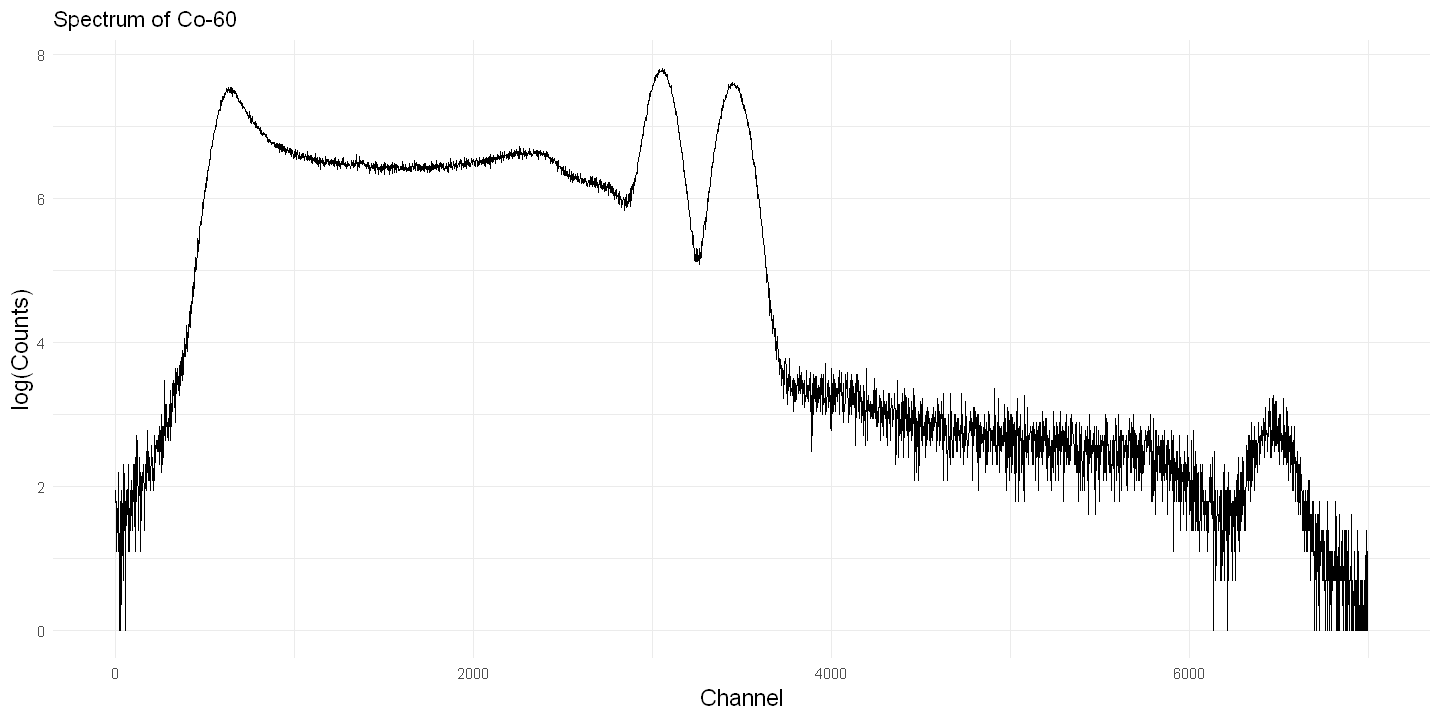

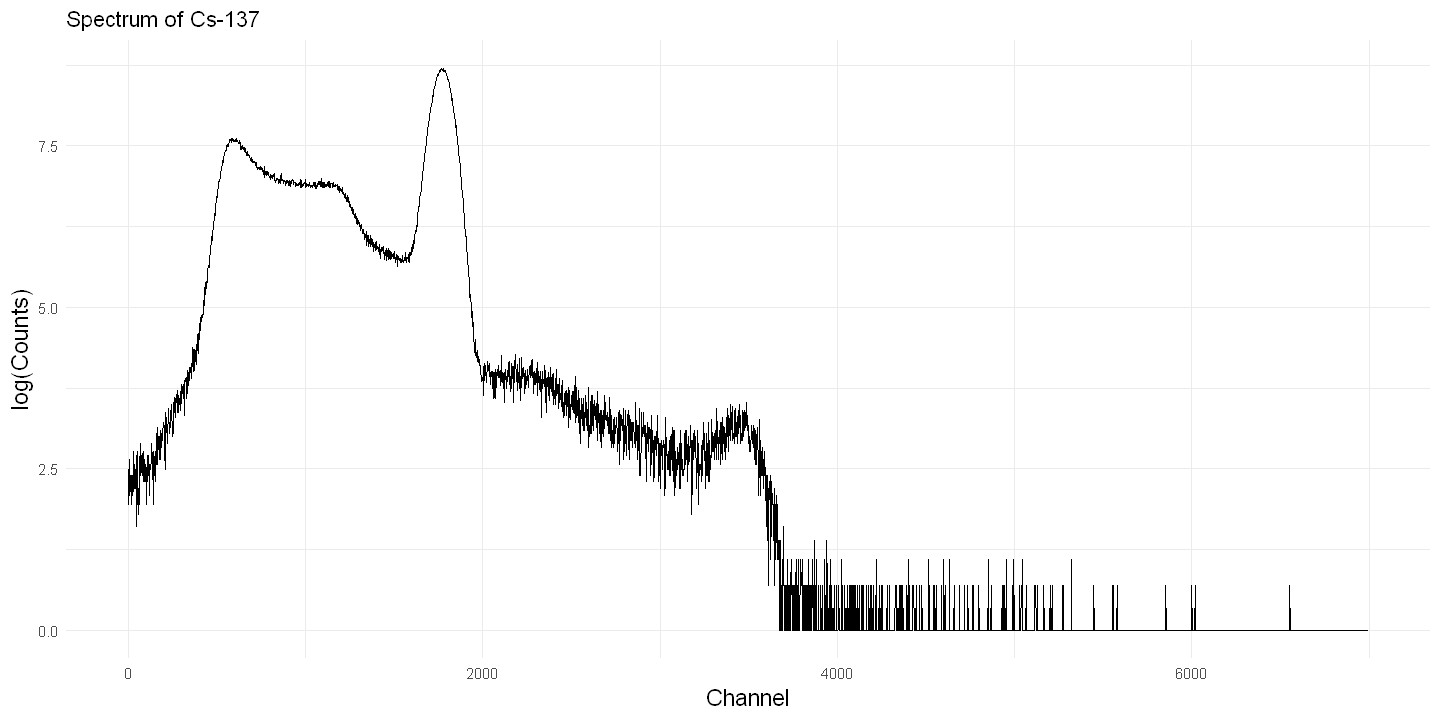

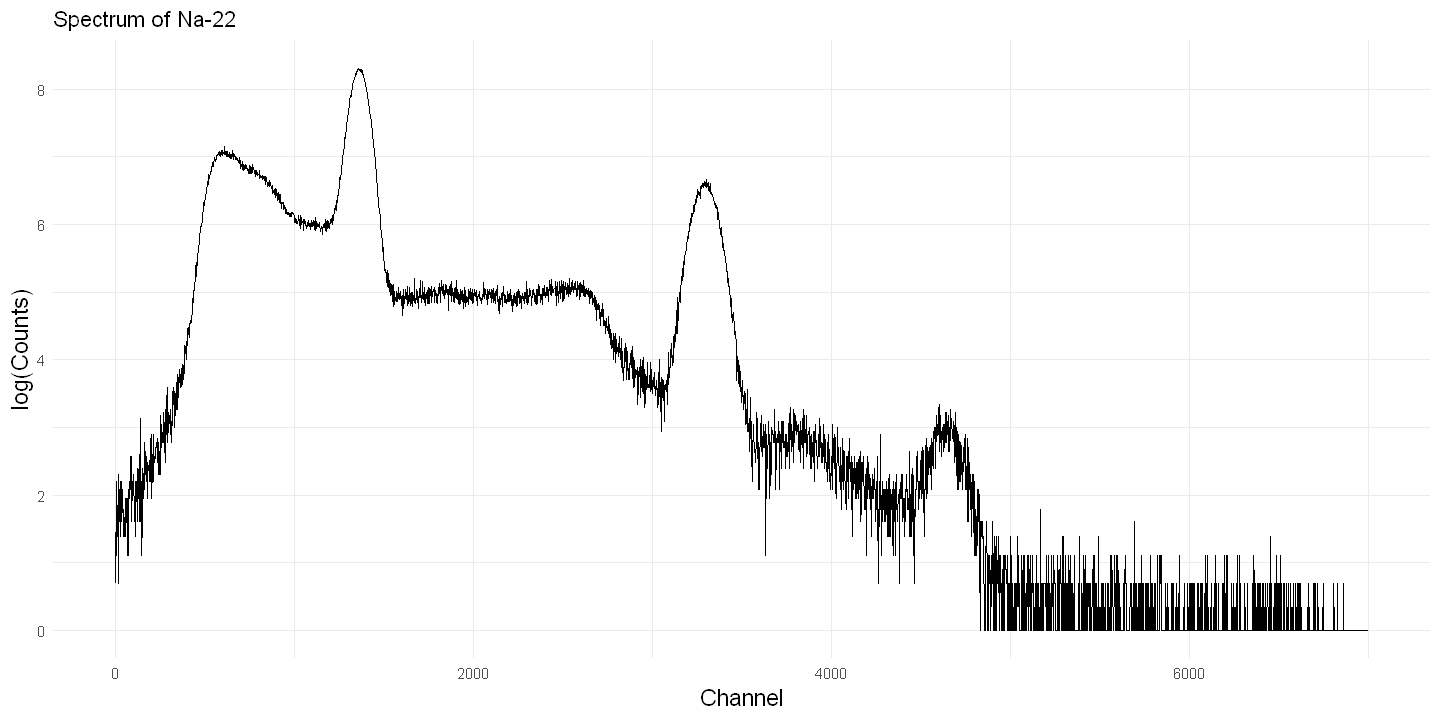

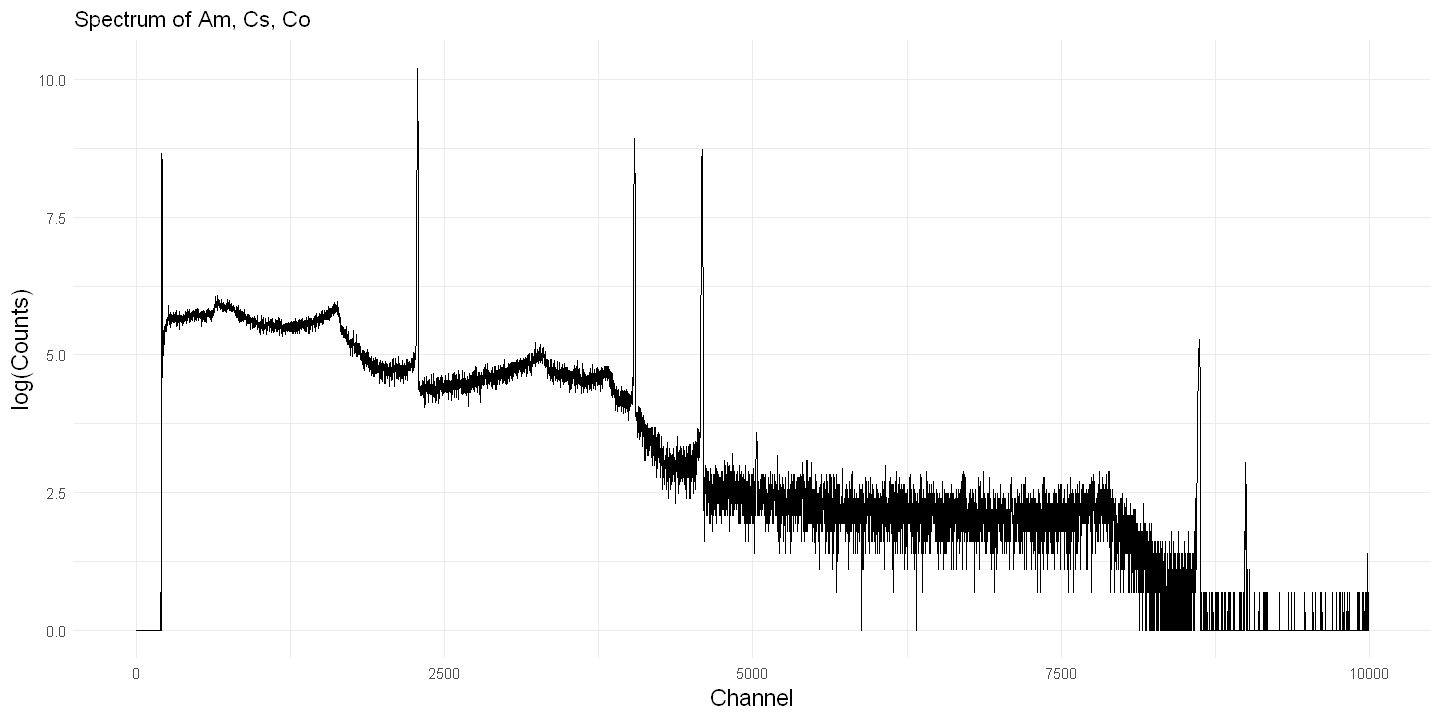

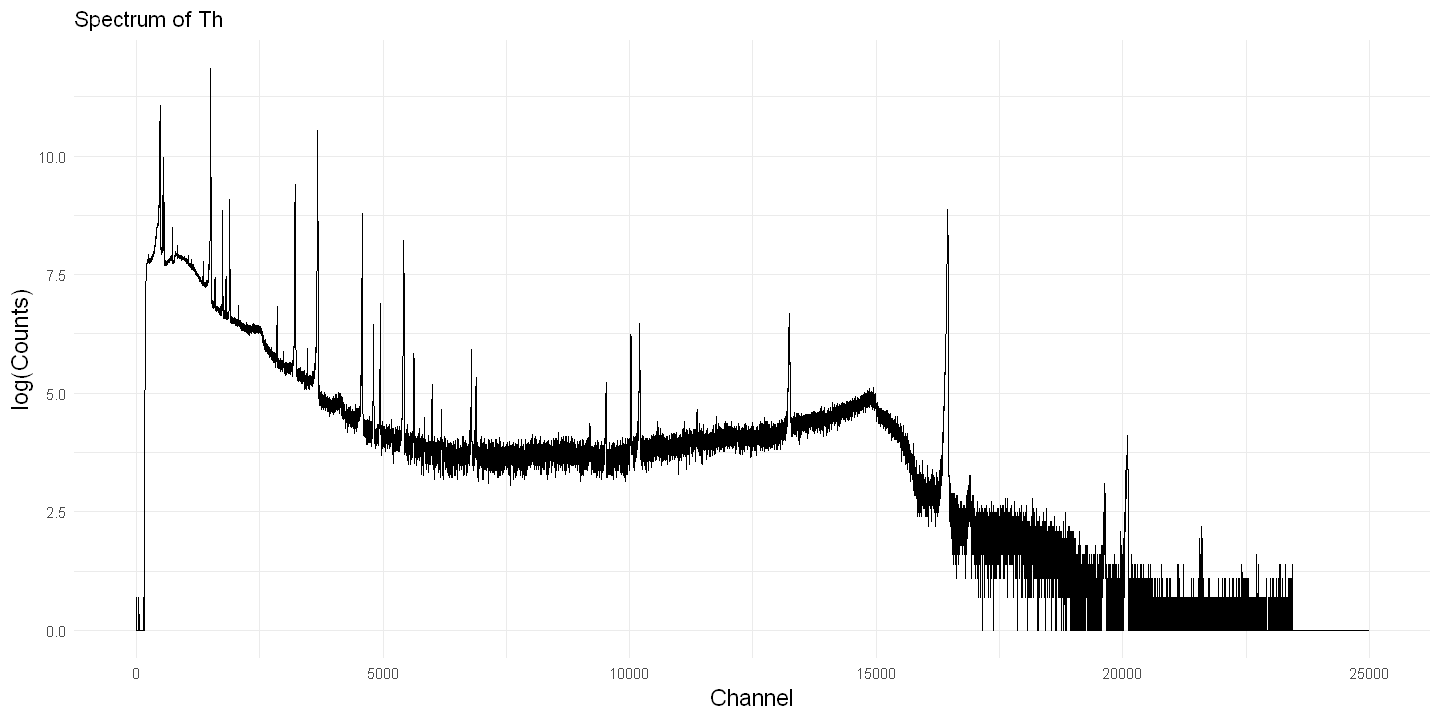

In [3]:
# Plot function
options(repr.plot.width = 12, repr.plot.height = 6)
plot_spectrum <- function(data, title) {
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line(col='black', lwd=0.2, na.rm = TRUE) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("log(Counts)") +
    theme_minimal() +
    #xlim(1, 6000)  +
    theme(axis.title = element_text(size = 14))
}

# Plot each spectrum
plot_spectrum(gr11_co60, "Spectrum of Co-60")
plot_spectrum(gr11_cs137, "Spectrum of Cs-137")
plot_spectrum(gr11_na22, "Spectrum of Na-22")
plot_spectrum(IC48A_AmCsCo, "Spectrum of Am, Cs, Co")
plot_spectrum(IC48A_Th, "Spectrum of Th")


### d. Find Peaks Precisely and Infer FWHM

La funzione movavg dalla libreria pracma viene utilizzata per applicare una media mobile semplice ai valori nella colonna Value. La media mobile aiuta a ridurre il rumore nei dati, facilitando l'identificazione dei picchi principali.
La media mobile viene calcolata su una finestra di dimensione window_size (5 per default).
I valori levigati vengono salvati in smoothed_values

I puntini rossi che vengono plottati corrispondono ai picchi effettivamente trovati dalla funzione find_local_peaks_around_x. Questa funzione trova i massimi locali nella colonna log_Count dei dati intorno ai valori di x_values che hai specificato.

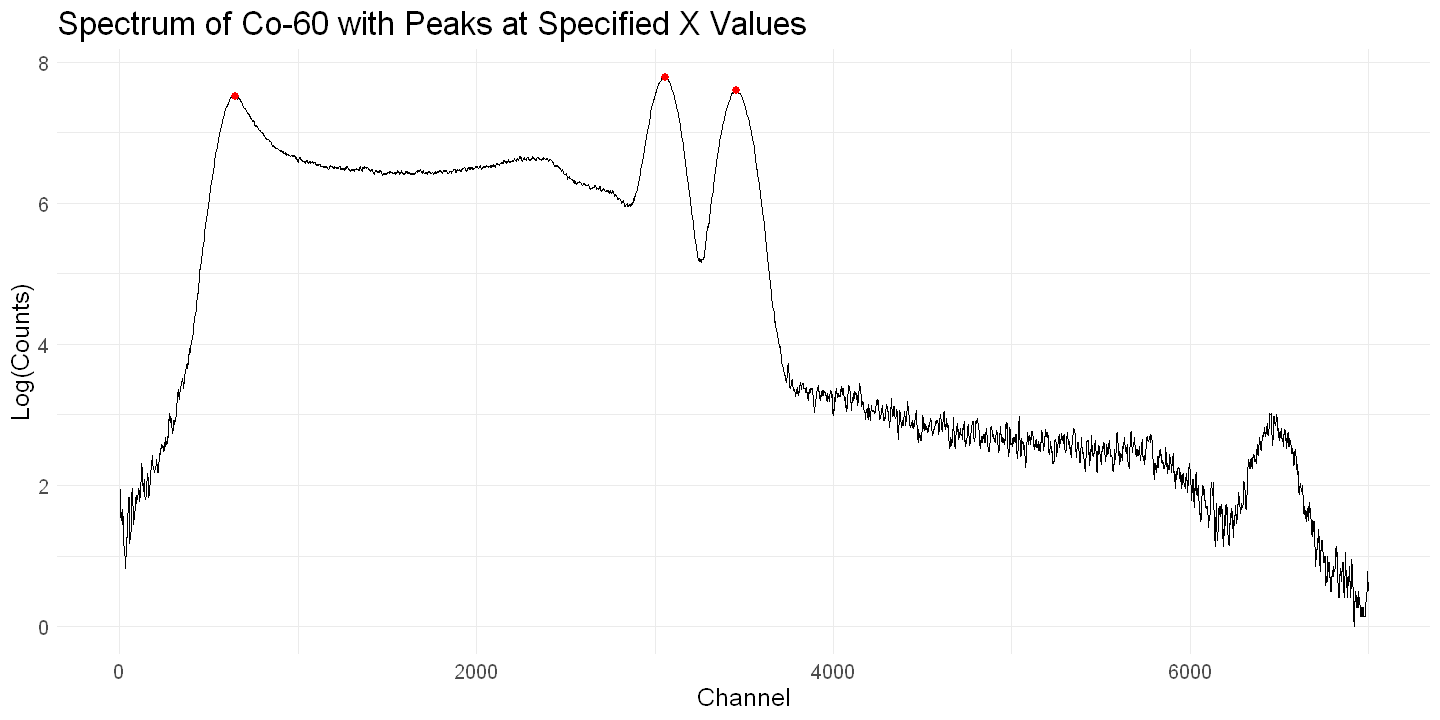

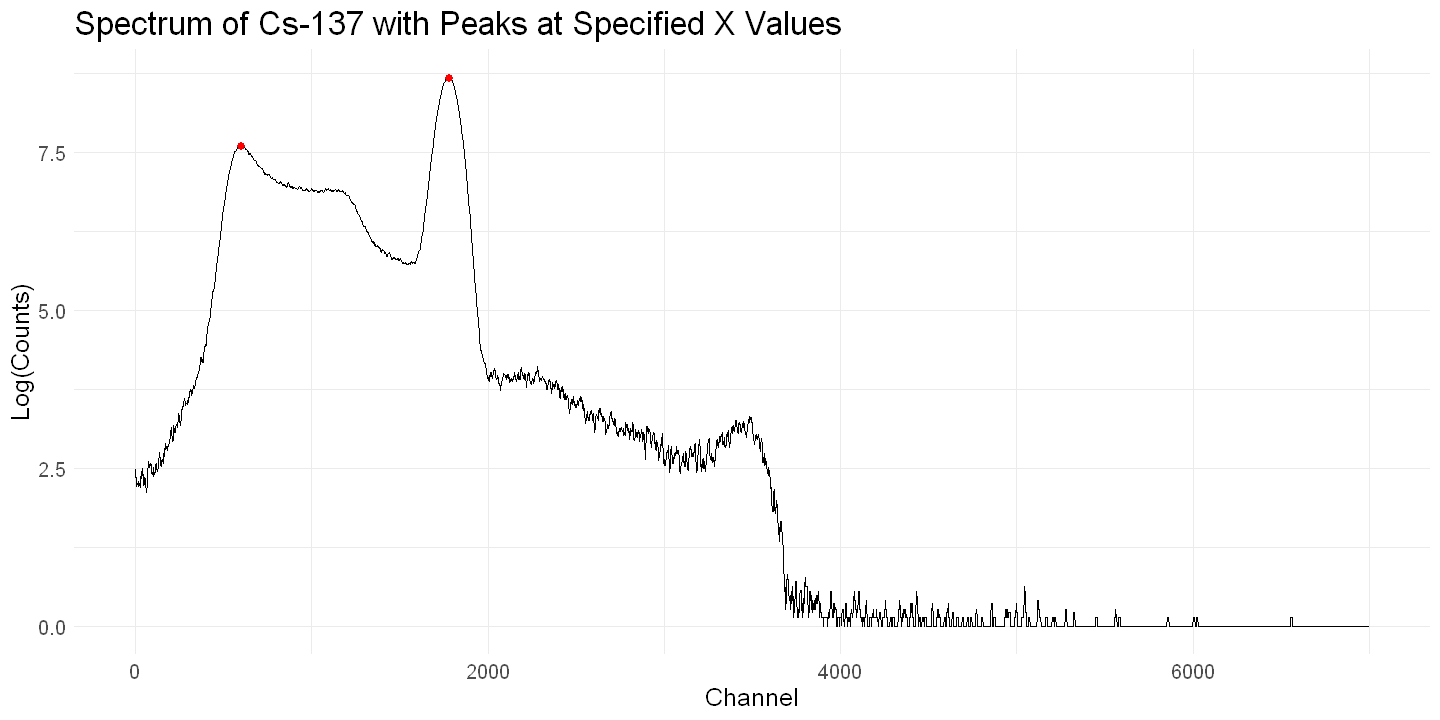

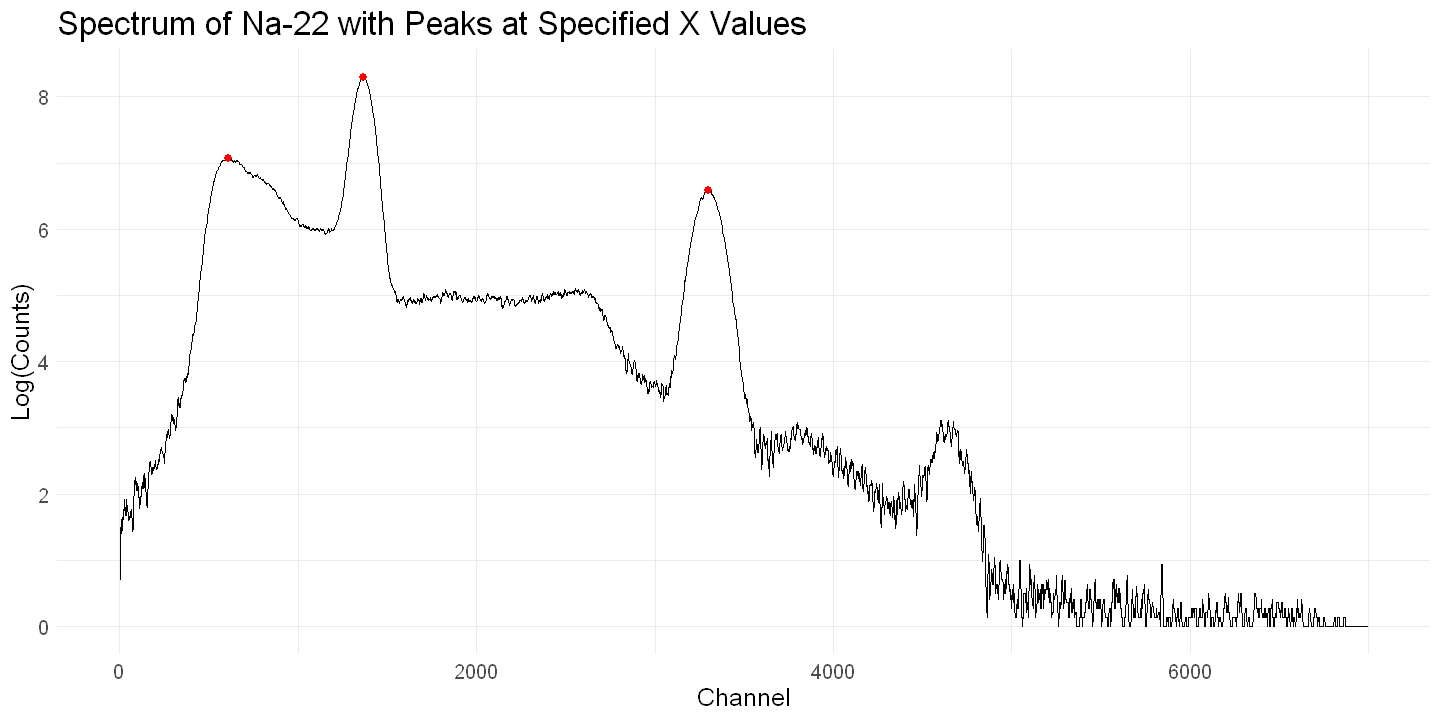

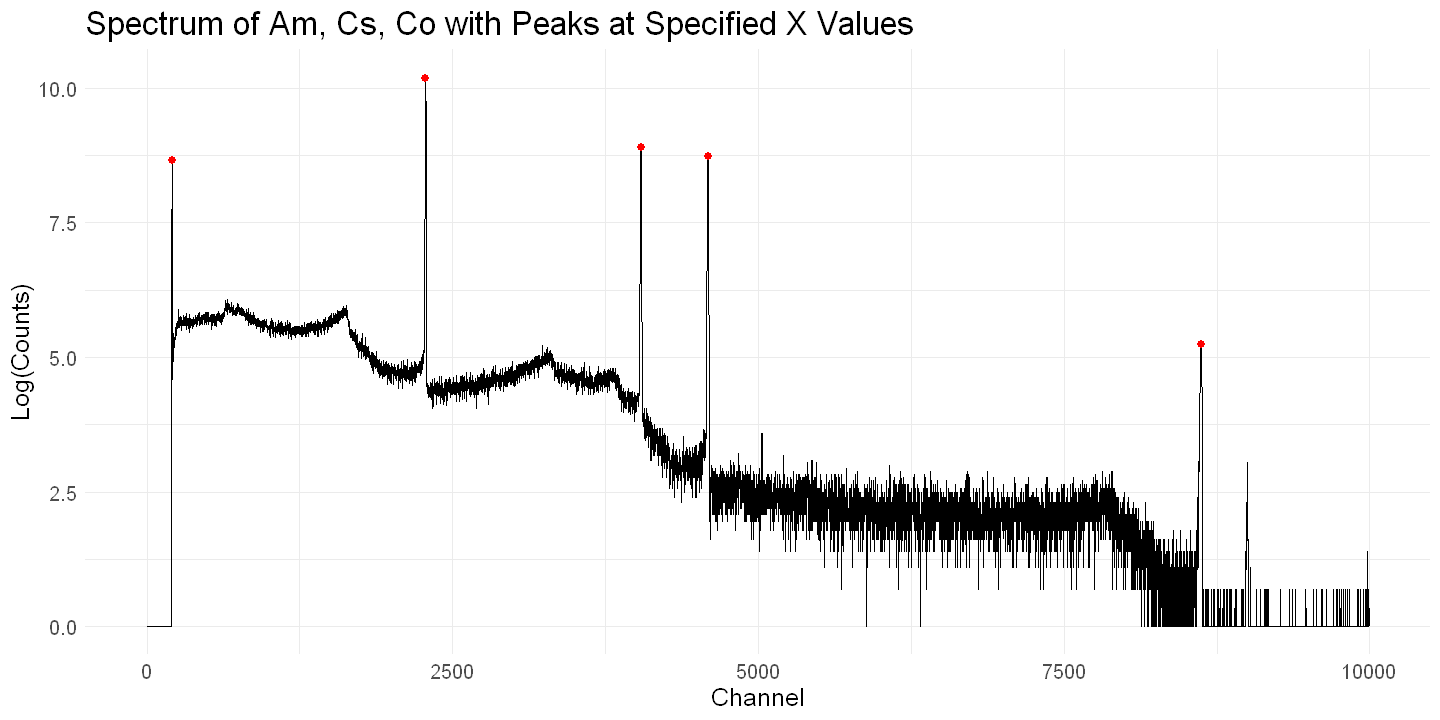

[1]  647 3057 3457

[1]  599 1779

[1]  609 1365 3301

[1]  206 2280 4041 4589 8623

[1]   485  1504  1890  3218  3674  4581  4948  5420  6793  9525 10025 10202
[13] 13240 16452 20099

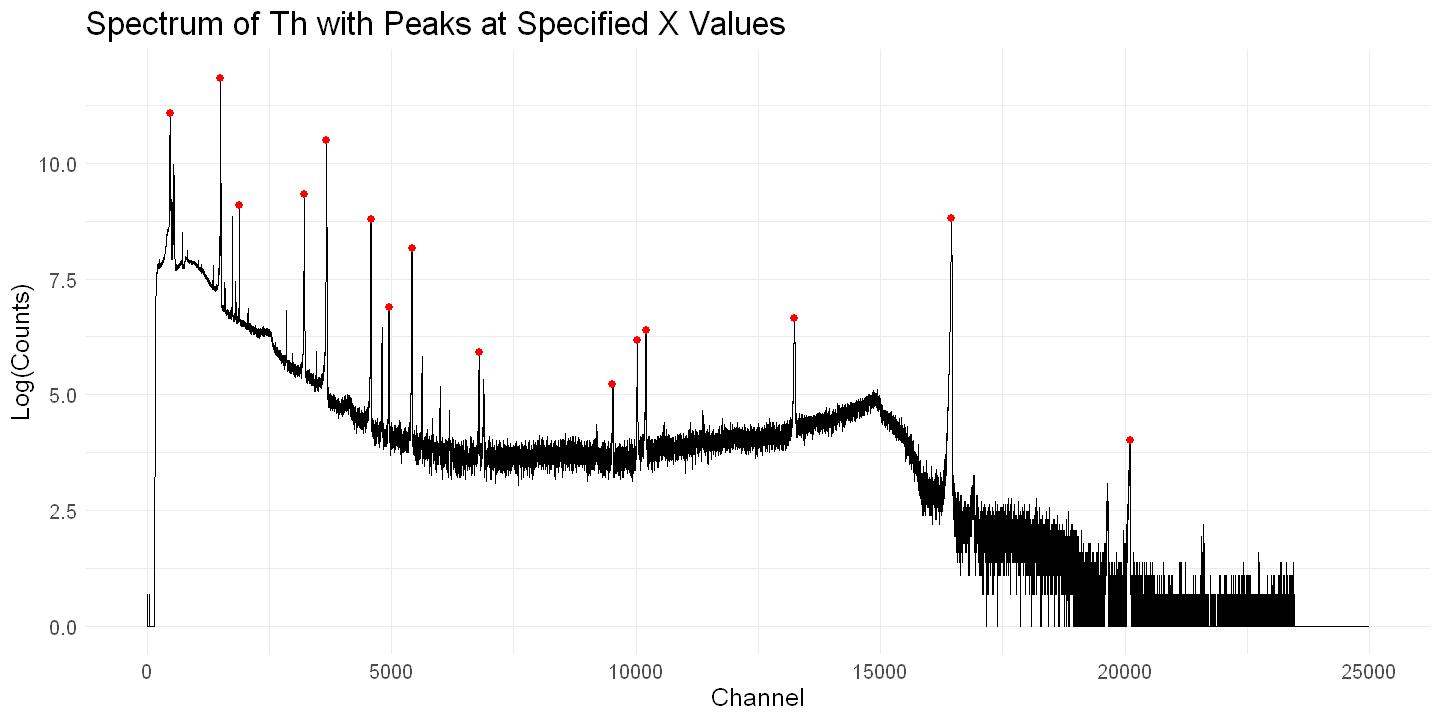

In [4]:
# Function to find indices of values closest to specified x values
find_indices_around_x <- function(data, x_values) {
  indices <- numeric(0)
  for (x_val in x_values) {
    index <- which.min(abs(data$Channel - x_val))
    indices <- c(indices, index)
  }
  return(indices)
}

# Function to smooth data
smooth_data <- function(data, window_size) {
  smoothed_values <- movavg(data$log_Count, n = window_size, type = "s")
  smoothed_data <- data
  smoothed_data$log_Count <- smoothed_values
  return(smoothed_data)
}

plot_peaks_around_x <- function(data, title, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    # Smooth the data
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  
  # Plot the data with red points at specified x values
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line() +
    geom_point(data = data[indices, ], aes(x = Channel, y = log_Count), color = "red", size = 2) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

find_and_return_peaks_around_x <- function(data, x_values, window_size, apply_smoothing = TRUE) {
  if (apply_smoothing) {
    # Smooth the data
    data <- smooth_data(data, window_size)
  }
  indices <- find_indices_around_x(data, x_values)
  # Get peak positions
  peak_positions <- data$Channel[indices]
  # Return peak positions
  return(peak_positions)
}

position_co60 <- c(647, 3058, 3458)
position_cs137 <- c(600, 1779)
position_na22 <- c(609, 1366, 3302)
position_AmCsCo<- c(206, 2280, 4041, 4589, 8623)
position_Th <- c( 485, 1504,1890,  3218, 3674, 4581,4948 , 5420, 6793, 9525, 10025, 10202,13240, 16452, 20099)
plot_peaks_around_x(gr11_co60, "Spectrum of Co-60 with Peaks at Specified X Values", x_values =position_co60, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_cs137, "Spectrum of Cs-137 with Peaks at Specified X Values", x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(gr11_na22, "Spectrum of Na-22 with Peaks at Specified X Values", x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
plot_peaks_around_x(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks at Specified X Values", x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
plot_peaks_around_x(IC48A_Th, "Spectrum of Th with Peaks at Specified X Values", x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

peaks_co60 <- find_and_return_peaks_around_x (gr11_co60, x_values = position_co60, window_size = 5, apply_smoothing = TRUE)
peaks_cs137 <- find_and_return_peaks_around_x (gr11_cs137, x_values = position_cs137, window_size = 5, apply_smoothing = TRUE)
peaks_na22 <- find_and_return_peaks_around_x (gr11_na22, x_values = position_na22, window_size = 5, apply_smoothing = TRUE)
peaks_AmCsCo <- find_and_return_peaks_around_x (IC48A_AmCsCo, x_values = position_AmCsCo, window_size = 8, apply_smoothing = FALSE)
peaks_Th <- find_and_return_peaks_around_x (IC48A_Th, x_values = position_Th, window_size = 8, apply_smoothing = FALSE)

peaks_co60
peaks_cs137
peaks_na22
peaks_AmCsCo
peaks_Th

In [5]:
# Extract data points around each peak
extract_peak_data <- function(data, peak_positions, window_size) {
  peak_data_list <- list()
  for (peak in peak_positions) {
    lower_bound <- max(1, peak - window_size)
    upper_bound <- min(nrow(data), peak + window_size)
    peak_data <- data[lower_bound:upper_bound, ]
    peak_data_list[[as.character(peak)]] <- peak_data
  }
  return(peak_data_list)
}

peak_data_list_AmCsCo <- extract_peak_data(IC48A_AmCsCo, peaks_AmCsCo, window_size = 50)
peak_data_list_Th <- extract_peak_data(IC48A_Th, peaks_Th, window_size = 50)
print(peak_data_list_AmCsCo)


$`206`
    Channel Count log_Count
156     155     0 0.0000000
157     156     0 0.0000000
158     157     0 0.0000000
159     158     0 0.0000000
160     159     0 0.0000000
161     160     0 0.0000000
162     161     0 0.0000000
163     162     0 0.0000000
164     163     0 0.0000000
165     164     0 0.0000000
166     165     0 0.0000000
167     166     0 0.0000000
168     167     0 0.0000000
169     168     0 0.0000000
170     169     0 0.0000000
171     170     0 0.0000000
172     171     0 0.0000000
173     172     0 0.0000000
174     173     0 0.0000000
175     174     0 0.0000000
176     175     0 0.0000000
177     176     0 0.0000000
178     177     0 0.0000000
179     178     0 0.0000000
180     179     0 0.0000000
181     180     0 0.0000000
182     181     0 0.0000000
183     182     0 0.0000000
184     183     0 0.0000000
185     184     0 0.0000000
186     185     0 0.0000000
187     186     0 0.0000000
188     187     0 0.0000000
189     188     0 0.0000000
190     189  

### e. Fit Gaussian and Calculate FWHM - - -   DA SISTEMARE ! - -  -
Vedere se trova le FWHM per tutti i picchi ( non so se vada fatto)- non mi sembra che fitti benissimo su tutti

Calcolo FWHM con metodo Gaussiano

In [6]:
# Function to fit Gaussian model using nls
fit_gaussian_nls <- function(peak_data) {
  # Initial guesses for the parameters
  mu_init <- peak_data$Channel[which.max(peak_data$log_Count)]
  sigma_init <- diff(range(peak_data$Channel)) / 4  # Quarter of the range
  A_init <- max(peak_data$log_Count)
  
  # Define the Gaussian function
  gaussian <- function(x, mu, sigma, A) {
    A * exp(-0.5 * ((x - mu) / sigma)^2)
  }
  
  # Fit the model using nls
  fit <- nls(log_Count ~ gaussian(Channel, mu, sigma, A), data = peak_data,
             start = list(mu = mu_init, sigma = sigma_init, A = A_init),
             control = nls.control(maxiter = 100))
  return(fit)
}


# Fit the model for each peak
fits_AmCsCo <- lapply(peak_data_list_AmCsCo, fit_gaussian_nls)
fits_Th <- lapply(peak_data_list_Th, fit_gaussian_nls)


In [7]:
# Function to calculate FWHM from fitted Gaussian parameters
calculate_fwhm <- function(fit) {
  coef_fit <- coef(fit)
  sigma <- coef_fit["sigma"]
  FWHM <- 2 * sqrt(2 * log(2)) * sigma
  return(FWHM)
}

# Calculate FWHM for each peak
fwhm_values_AmCsCo <- sapply(fits_AmCsCo, calculate_fwhm)
fwhm_values_Th <- sapply(fits_Th, calculate_fwhm)
print(fwhm_values_AmCsCo)
print(fwhm_values_Th)


 206.sigma 2280.sigma 4041.sigma 4589.sigma 8623.sigma 
  58.34529  113.60375   98.59698   70.72224   30.82972 
  485.sigma  1504.sigma  1890.sigma  3218.sigma  3674.sigma  4581.sigma 
  243.93417   132.03734   217.54721   121.84996   100.36421   104.35655 
 4948.sigma  5420.sigma  6793.sigma  9525.sigma 10025.sigma 10202.sigma 
  130.33953    96.80037   138.30798   153.03026   128.99338   118.26166 
13240.sigma 16452.sigma 20099.sigma 
  121.83213    80.02592    62.33207 


FWHM con interpolazione

In [8]:
# Function to calculate FWHM using interpolation
calculate_fwhm_interpolation <- function(peak_data) {
  # Find maximum count and corresponding channel
  max_count <- max(peak_data$Count)
  max_channel <- peak_data$Channel[which.max(peak_data$Count)]
  
  # Find half-maximum value
  half_max <- max_count / 2
  
  # Interpolate to find FWHM
  interpolate_fwhm <- function(x, y, half_max) {
    approx(x, y - half_max, xout = half_max)$x
  }
  
  # Find left and right half-maximum points
  left_half_max <- interpolate_fwhm(peak_data$Channel, peak_data$Count, half_max)
  right_half_max <- interpolate_fwhm(rev(peak_data$Channel), rev(peak_data$Count), half_max)
  
  # Calculate FWHM
  fwhm <- right_half_max - left_half_max
  
  if (is.na(fwhm)) {
    stop("Failed to determine FWHM using interpolation.")
  }
  
  return(fwhm)
}

# Calculate FWHM for each peak using interpolation
#fwhm_values <- sapply(peak_data_list_AmCsCo, calculate_fwhm_interpolation)
#fwhm_values_Th <- sapply(peak_data_list_Th, calculate_fwhm_interpolation)
#print(fwhm_values_AmCsCo)
#print(fwhm_values_Th)


## Step 2: Calibration of Detector
To perform a calibration of the detector, we need to establish a relationship between the channel number (position of the peak) and the known energies of the gamma peaks. Assuming a linear response, this relationship can be expressed as:
$$ E=a⋅x+b $$

where:
* E is the energy in keV,
* x is the channel number,
* a and b are the calibration constants.
We can perform this calibration using a set of known gamma energies corresponding to the detected peaks.

##### Steps to Perform Calibration
Identify Known Gamma Energies: We need to have the nominal gamma peak energies for the isotopes in the data.  
Fit the Line: Use the identified peak positions (centroids) and their corresponding gamma energies to fit a linear model.  
Apply Calibration: Use the linear model to convert channel numbers to energies.  


Call:
lm(formula = Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)

Residuals:
      1       2       3       4       5 
 0.5032 -0.1498 -0.3804 -0.3823  0.4093 

Coefficients:
                 Estimate Std. Error  t value Pr(>|t|)    
(Intercept)    -8.324e-01  3.829e-01   -2.174    0.118    
Channel_AmCsCo  2.906e-01  7.915e-05 3671.859 4.45e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4947 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.348e+07 on 1 and 3 DF,  p-value: 4.455e-11



Call:
lm(formula = Energy_Th ~ Channel_Th, data = calibration_data_Th)

Residuals:
     Min       1Q   Median       3Q      Max 
-240.233  -53.706    0.797   72.222  194.619 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.070e+02  4.970e+01   4.164  0.00111 ** 
Channel_Th  1.167e-01  5.347e-03  21.833 1.25e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 114.6 on 13 degrees of freedom
Multiple R-squared:  0.9735,	Adjusted R-squared:  0.9714 
F-statistic: 476.7 on 1 and 13 DF,  p-value: 1.253e-11


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


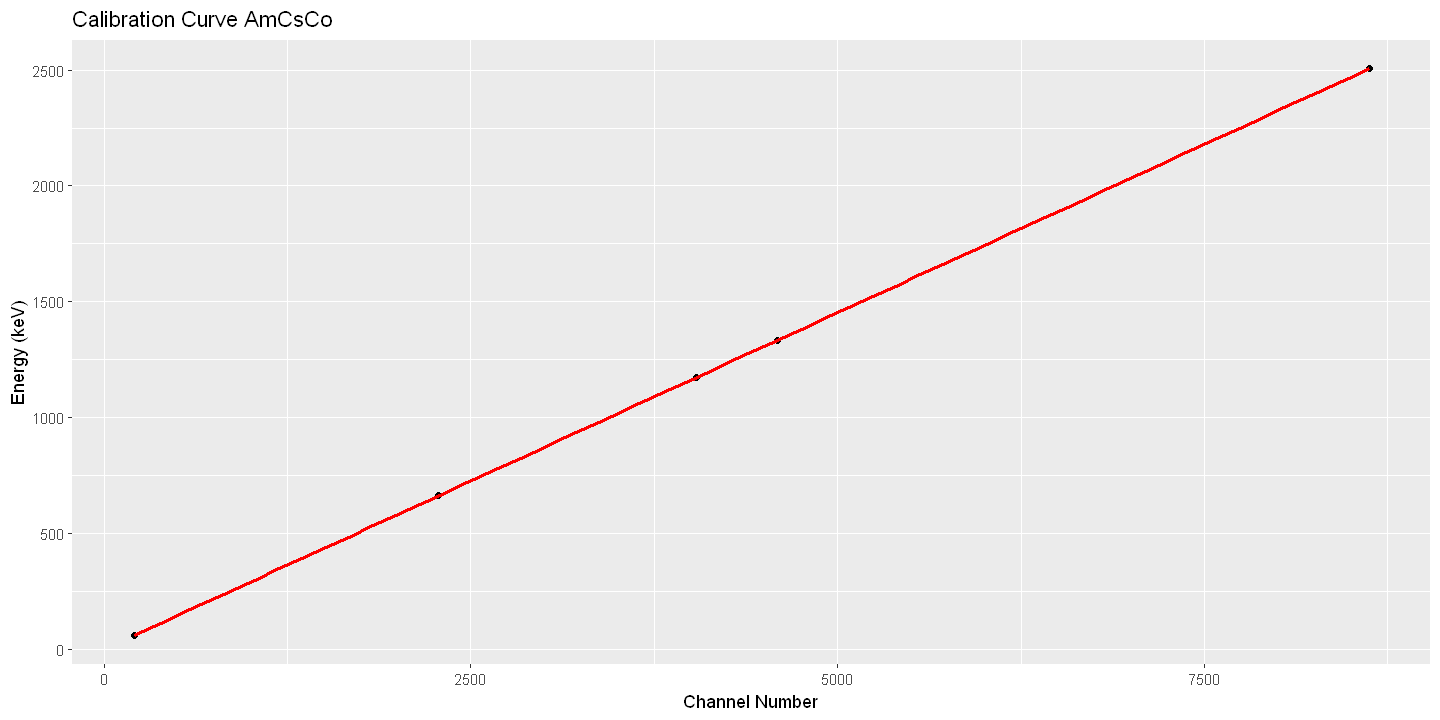

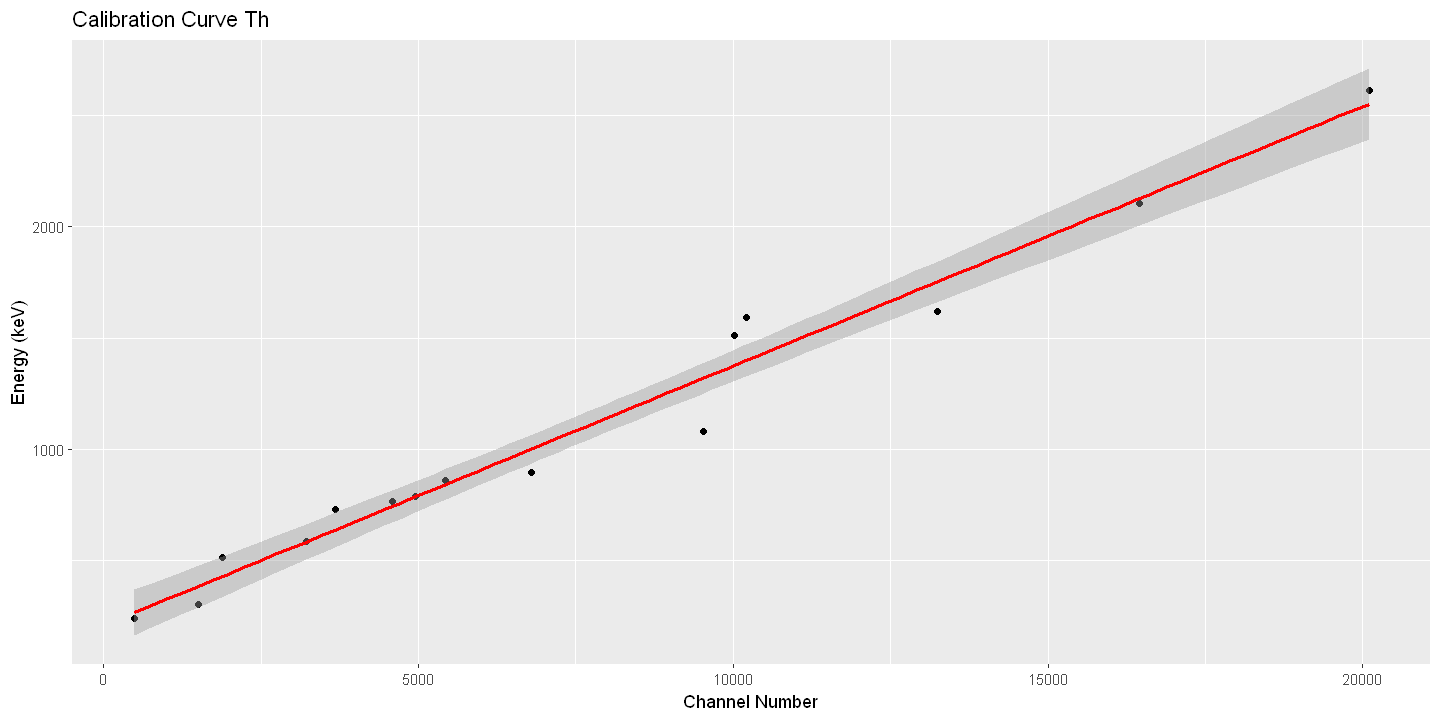

In [9]:
# Given gamma energies (in keV) corresponding to the detected peaks
AmCsCo_energies <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)
Th_energies <- c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45 , 785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

# Create a data frame with the positions and corresponding energies
calibration_data_AmCsCo <- data.frame(
  Channel_AmCsCo = peaks_AmCsCo,
  Energy_AmCsCo = AmCsCo_energies
)
calibration_data_Th <- data.frame(
  Channel_Th = peaks_Th,
  Energy_Th = Th_energies
)

# Fit the linear model
calibration_model_AmCsCo <- lm(Energy_AmCsCo ~ Channel_AmCsCo, data = calibration_data_AmCsCo)
calibration_model_Th <- lm(Energy_Th ~ Channel_Th, data = calibration_data_Th)
summary(calibration_model_AmCsCo)
summary(calibration_model_Th)

# Plot the calibration data and the fitted model
ggplot(calibration_data_AmCsCo, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

ggplot(calibration_data_Th, aes(x = Channel_Th, y = Energy_Th)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")


Warning message in data.frame(Channel_AmCsCo = calibration_data_AmCsCo$Channel_AmCsCo, :
"row.names ricavati da una variabile con pochi elementi e quindi non utlizzabili"


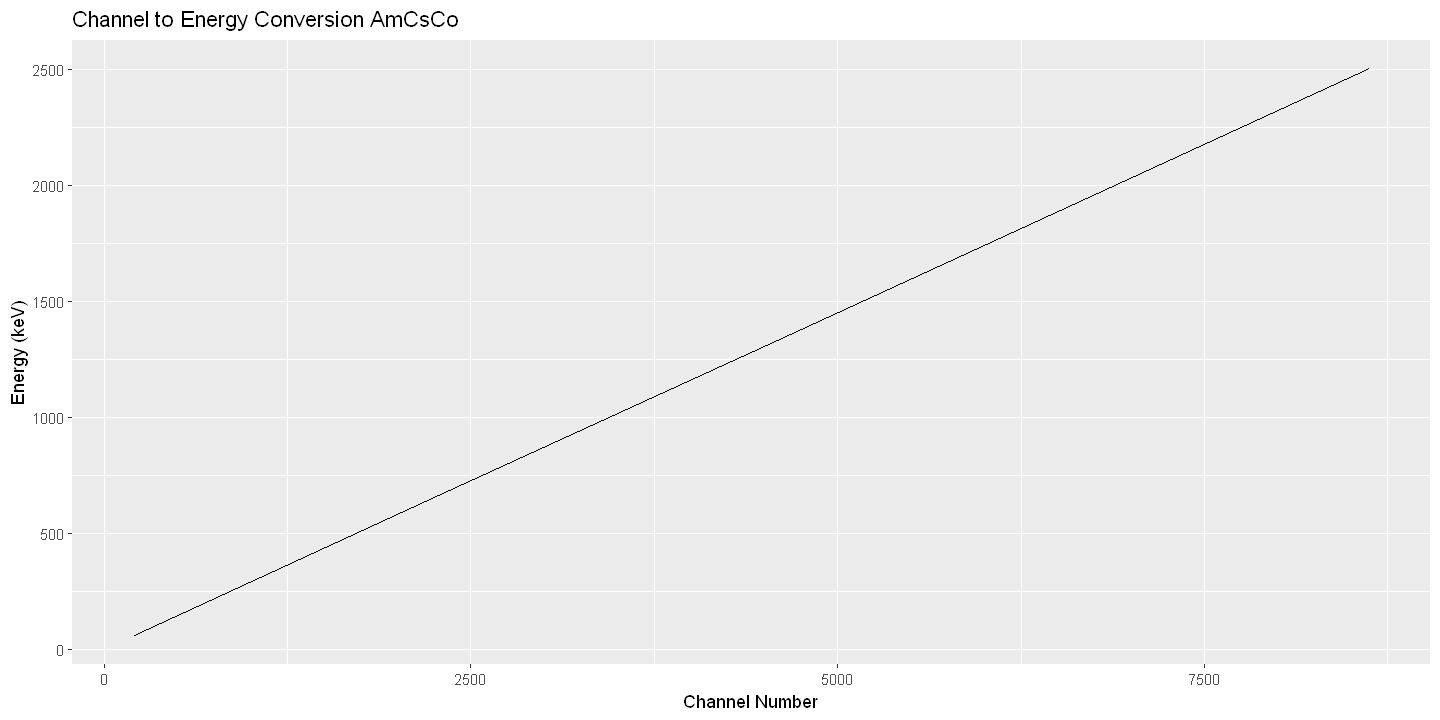

         1          2          3          4          5 
  59.03767  661.80683 1173.60841 1332.87432 2505.28067 


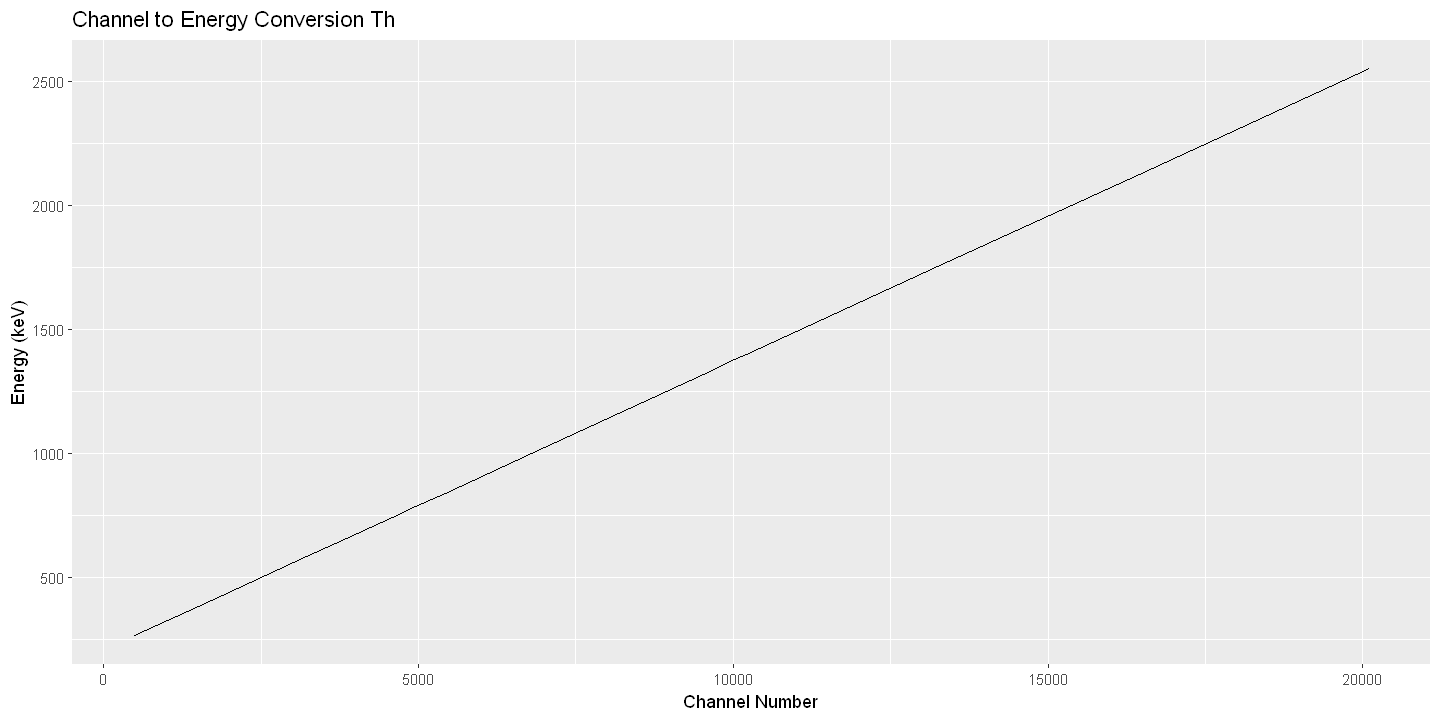

In [10]:
# Define the function to convert channel to energy
channel_to_energy <- function(channel, model, predictor) {
  predict(model, newdata = setNames(data.frame(channel), predictor))
}

# Apply calibration to the channels
energies_AmCsCo <- channel_to_energy(calibration_data_AmCsCo$Channel_AmCsCo, calibration_model_AmCsCo, "Channel_AmCsCo")
energies_Th <- channel_to_energy(calibration_data_Th$Channel_Th, calibration_model_Th, "Channel_Th")

# Create a data frame with channels and corresponding energies
calibrated_data <- data.frame(Channel_AmCsCo = calibration_data_AmCsCo$Channel_AmCsCo,
                              Channel_Th = calibration_data_Th$Channel_Th,
                              Energy_AmCsCo = energies_AmCsCo,
                              Energy_Th = energies_Th)

# Load ggplot2 library for plotting
library(ggplot2)

# Plot the calibration results for AmCsCo
ggplot(calibrated_data, aes(x = Channel_AmCsCo, y = Energy_AmCsCo)) +
  geom_line() +
  ggtitle("Channel to Energy Conversion AmCsCo") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

# Plot the calibration results for Th
ggplot(calibrated_data, aes(x = Channel_Th, y = Energy_Th)) +
  geom_line() +
  ggtitle("Channel to Energy Conversion Th") +
  xlab("Channel Number") +
  ylab("Energy (keV)")
print(energies_AmCsCo)


### Step 3: Study Energy Resolution Using MCMC:
Using MCMC methods (with either JAGS or Stan), study the behavior of energy resolution as a function of photon energy.
Infer the parameters of the equations for FWHM and its components.

To study the behavior of the energy resolution as a function of the photon energy and infer the parameters using a Bayesian approach (with either JAGS or Stan), we need to model the Full Width at Half Maximum (FWHM) in terms of the provided equations.

##### Equations
$$ FWHM= \sqrt{(w_d^2+w_e^2)} $$
$$ w_d = 2  \sqrt{(2 \cdot \log(2)) \cdot F \cdot E_{\gamma} \cdot w}​ $$
 
Here, $E_\gamma$ is the photon energy, F is a parameter, and w is a parameter related to the detector.

##### Steps
* Model Definition: Define the Bayesian model using the equations.
* Data Preparation: Prepare the data for MCMC analysis.
* MCMC Simulation: Use Stan to run the MCMC simulation and infer the parameters.
* Result Analysis: Analyze the results to understand the behavior of energy resolution.
1. Model Definition
We need to translate the given equations into a form that can be used with MCMC methods. The parameters to be inferred are $w_e$,F, and w.  

We'll start by rearranging the equations:

* Substitute $w_d$ into the first equation.
##### Stan Model
Let's define a Stan model for the FWHM as a function of photon energy.

In [11]:
# Define the Stan model
stan_model_code <- "
data {
  int<lower=0> N; // number of observations
  vector[N] E_gamma; // photon energy values
  vector[N] FWHM; // FWHM values
}
parameters {
  real<lower=0> F;
  real<lower=0> w;
  real<lower=0> w_e;
}
model {
  vector[N] w_d;
  for (i in 1:N) {
    w_d[i] = 2 * sqrt(2 * log(2) * F * E_gamma[i] * w);
  }
  FWHM ~ normal(sqrt(w_d .* w_d + w_e * w_e), 0.1);
}
"


2. Data Preparation  
We will use the energies and FWHM values from your data. Here are the values you provided earlier:

In [12]:
# Prepare data for Stan
stan_data_AmCsCo <- list(
  N = length(energies_AmCsCo),
  E_gamma = energies_AmCsCo,
  FWHM = fwhm_values_AmCsCo
)
stan_data_Th <- list(
  N = length(energies_Th),
  E_gamma = energies_Th,
  FWHM = fwhm_values_Th
)

3. MCMC Simulation  
Compile the Stan model and run the MCMC simulation:

In [13]:
# Compile the model
stan_model_AmCsCo <- stan(model_code = stan_model_code,
                   data = stan_data_AmCsCo,
                   iter = 2000,
                   chains = 4,
                   control = list(max_treedepth = 10))
# Print the summary of the model
print(stan_model_AmCsCo)

Warning message:
"There were 501 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 1078 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean   sd       2.5%        25%          50%
F     4.947366e+298     NaN  Inf       0.00       0.00         0.00
w     5.988404e+299     NaN  Inf       0.00       0.00 327823490.72
w_e    7.442000e+01    0.00 0.05      74.33      74.39        74.42
lp__  -2.146139e+05    0.03 1.09 -214616.86 -214614.31   -214613.52
                75%          97.5% n_eff Rhat
F     6.711847e+135  5.779162e+282   NaN  NaN
w     1.767784e+157  5.292442e+293   NaN  NaN
w_e    7.445000e+01   7.451000e+01  1917    1
lp__  -2.146131e+05  -2.146128e+05  1200    1

Samples were drawn using NUTS(diag_e) at Fri Jul 12 22:08:07 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
stan_model_Th <- stan(model_code = stan_model_code,
                   data = stan_data_Th,
                   iter = 2000,
                   chains = 4,
                   control = list(max_treedepth = 10))

print(stan_model_Th)

Warning message:
"There were 39 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 1085 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 3.06, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
htt

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean   se_mean       sd        2.5%         25%         50%
F     6.127267e+287       NaN      Inf        0.00        0.00        1.81
w     8.527246e+296       NaN      Inf        0.00        0.00        0.21
w_e    1.125400e+02     12.49     29.4       22.51       97.56      127.80
lp__  -2.097413e+06 423372.89 788889.2 -4087105.68 -2777199.13 -1628856.40
             75%          97.5% n_eff Rhat
F           2.01  1.726590e+224   NaN  NaN
w           0.92  3.309282e+267   NaN  NaN
w_e       130.00   1.300400e+02     6 1.62
lp__ -1561789.00  -1.561788e+06     3 2.12

Samples were drawn using NUTS(diag_e) at Fri Jul 12 22:08:20 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


4. Result Analysis  
Extract the results and analyze the parameters:

Estimated parameters:
F: 4.947366e+298 
w: 5.988404e+299 
w_e: 74.42007 


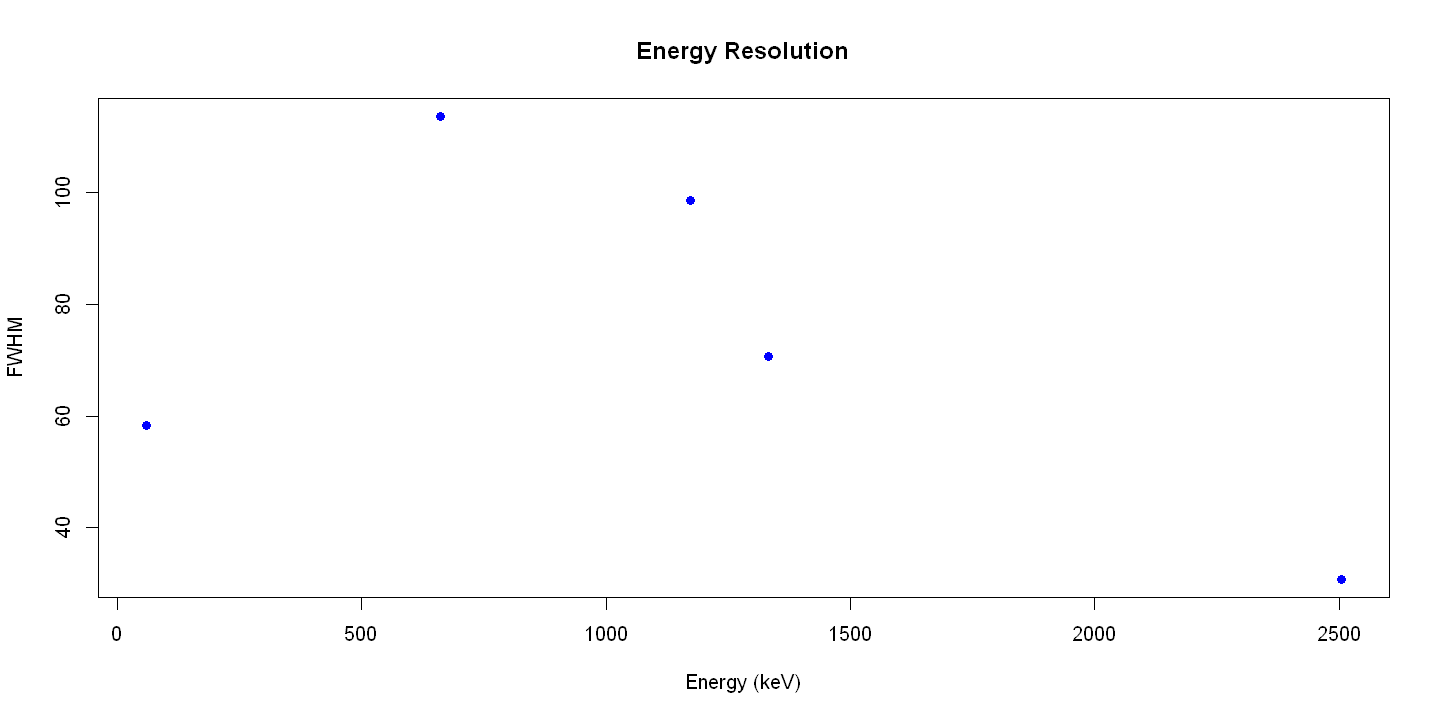

In [15]:
# Extract results
results <- extract(stan_model_AmCsCo)

# Get the posterior estimates for the parameters
F_est <- mean(results$F)
w_est <- mean(results$w)
w_e_est <- mean(results$w_e)

# Print the estimated parameters
cat("Estimated parameters:\n")
cat("F:", F_est, "\n")
cat("w:", w_est, "\n")
cat("w_e:", w_e_est, "\n")

# Plot the energy resolution function
energy_range <- seq(min(energies_AmCsCo), max(energies_AmCsCo), length.out = 100)
w_d <- 2 * sqrt(2 * log(2) * F_est * energy_range * w_est)
predicted_fwhm <- sqrt(w_d^2 + w_e_est^2)

plot(energies_AmCsCo, fwhm_values_AmCsCo, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution")
lines(energy_range, predicted_fwhm, col = "red")


Estimated parameters:
F: 6.127267e+287 
w: 8.527246e+296 
w_e: 112.5412 


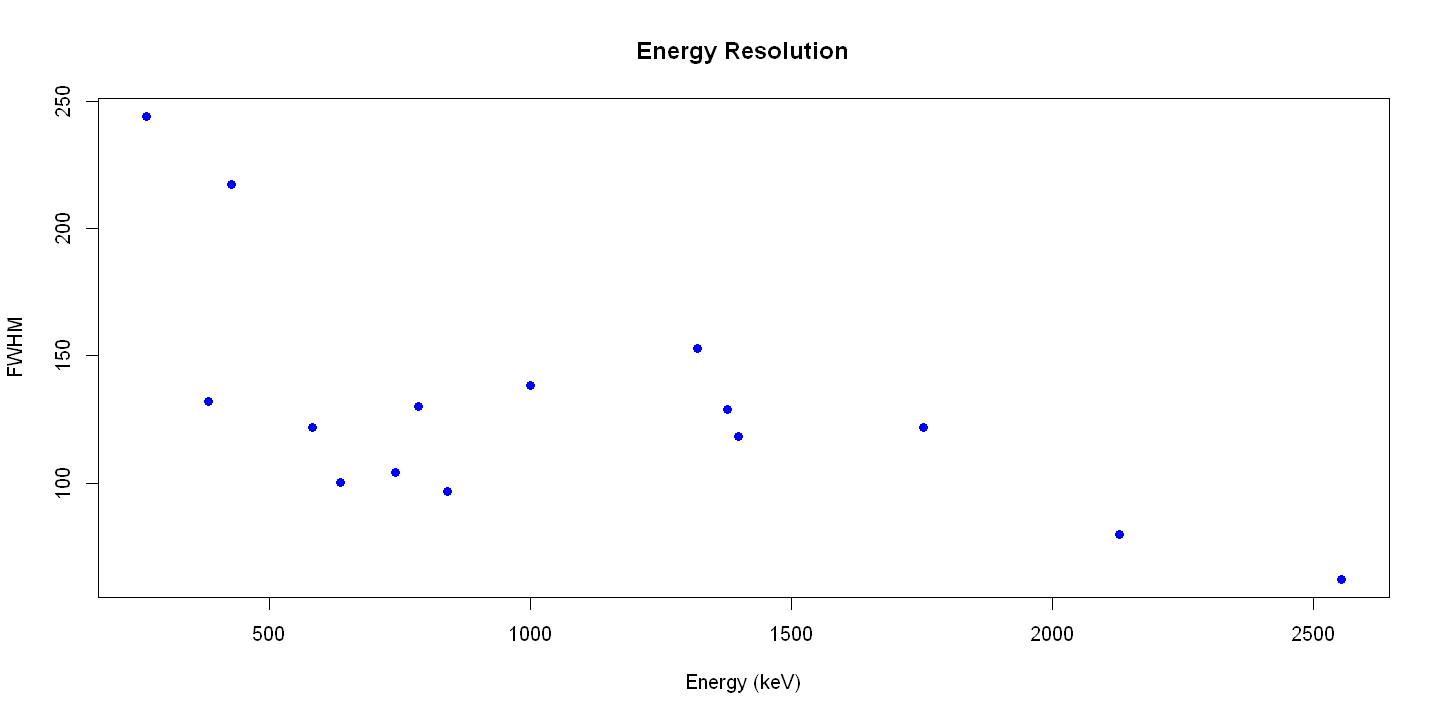

In [16]:
# Extract results
results <- extract(stan_model_Th)

# Get the posterior estimates for the parameters
F_est <- mean(results$F)
w_est <- mean(results$w)
w_e_est <- mean(results$w_e)

# Print the estimated parameters
cat("Estimated parameters:\n")
cat("F:", F_est, "\n")
cat("w:", w_est, "\n")
cat("w_e:", w_e_est, "\n")

# Plot the energy resolution function
energy_range <- seq(min(energies_Th), max(energies_Th), length.out = 100)
w_d <- 2 * sqrt(2 * log(2) * F_est * energy_range * w_est)
predicted_fwhm <- sqrt(w_d^2 + w_e_est^2)

plot(energies_Th, fwhm_values_Th, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution")
lines(energy_range, predicted_fwhm, col = "red")

In [17]:
library(rjags)

# Define JAGS model code
jags_model_code <- "
model {
  for (i in 1:N) {
    w_d[i] <- 2 * sqrt(2 * log(2) * F * E_gamma[i] * w)
    FWHM[i] ~ dnorm(sqrt(w_d[i]^2 + w_e^2), prec)
  }
  
  F ~ dunif(0, 10)   # Prior uniforme per F
  w ~ dunif(0, 10)  # Prior uniforme per w
  w_e ~ dunif(0, 10)  # Prior uniforme per w_e
}
"

# Prepare data for JAGS
jags_data_AmCsCo <- list(
  N = length(energies_AmCsCo),
  E_gamma = energies_AmCsCo,
  FWHM = fwhm_values_AmCsCo,
  prec = 0.1  # Precisione per la distribuzione normale
)

# Compile and run the JAGS model
jags_model_AmCsCo <- jags.model(textConnection(jags_model_code), data = jags_data_AmCsCo, n.chains = 4)
update(jags_model_AmCsCo, 1000)  # Burn-in di 1000 iterazioni
jags_samples_AmCsCo <- coda.samples(jags_model_AmCsCo, variable.names = c("F", "w", "w_e"), n.iter = 2000)

# Print summary of JAGS model
print(summary(jags_samples_AmCsCo))


Caricamento del pacchetto richiesto: coda


Caricamento pacchetto: 'coda'


Il seguente oggetto è mascherato da 'package:rstan':

    traceplot


Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 50

Initializing model


Iterations = 2001:4000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean     SD Naive SE Time-series SE
F   2.7127 2.4307 0.027176       0.270375
w   0.5613 0.5037 0.005632       0.053153
w_e 9.7161 0.2916 0.003260       0.007668

2. Quantiles for each variable:

      2.5%    25%    50%    75% 97.5%
F   0.3653 0.6759 1.7994 4.2891 8.972
w   0.0698 0.1457 0.3475 0.9215 1.702
w_e 8.9099 9.6169 9.8085 9.9159 9.993



Estimated parameters (JAGS):
F: 2.712743 
w: 0.5612726 
w_e: 9.716084 


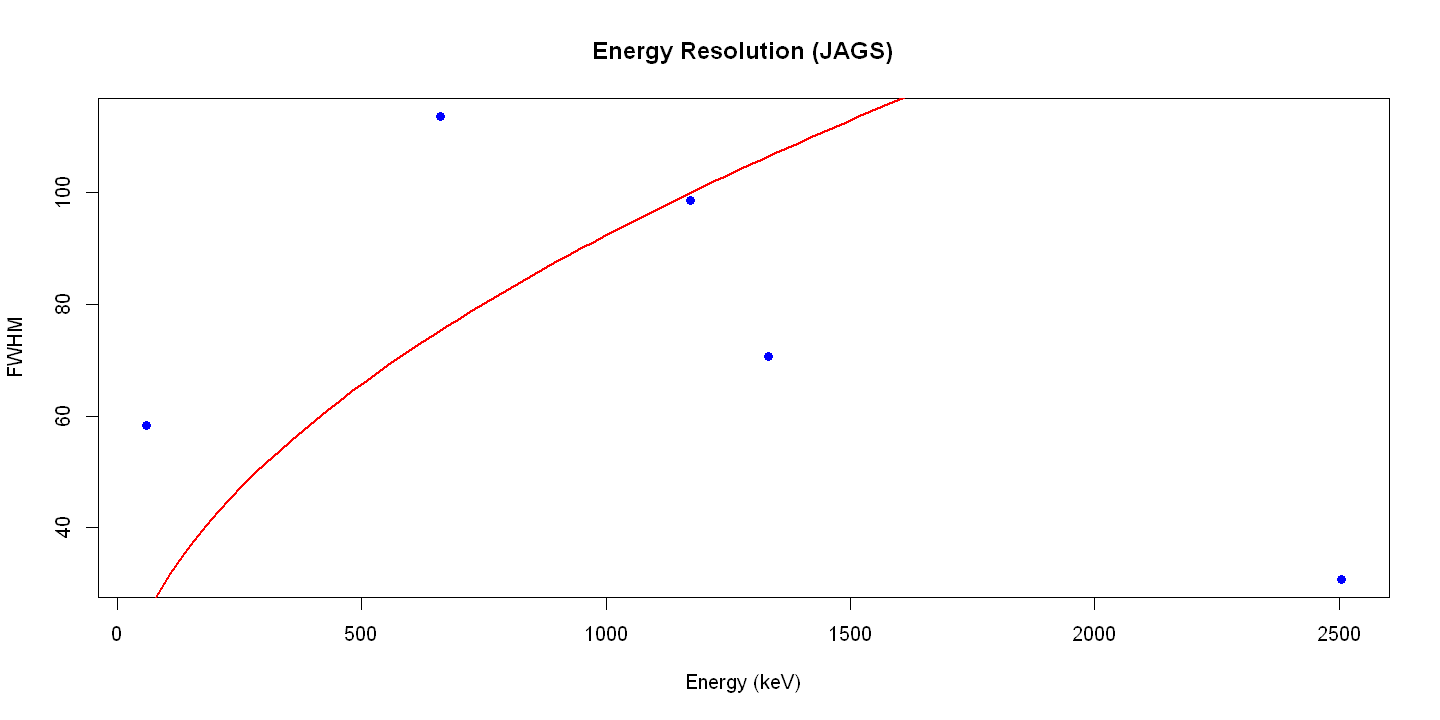

In [18]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_AmCsCo)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_AmCsCo), max(energies_AmCsCo), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_AmCsCo, fwhm_values_AmCsCo, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)

In [20]:
# Prepare data for JAGS
jags_data_Th <- list(
  N = length(energies_Th),
  E_gamma = energies_Th,
  FWHM = fwhm_values_Th,
  prec = 0.1  # Precisione per la distribuzione normale
)

# Compile and run the JAGS model
jags_model_Th <- jags.model(textConnection(jags_model_code), data = jags_data_Th, n.chains = 4)
update(jags_model_Th, 1000)  # Burn-in di 1000 iterazioni
jags_samples_Th <- coda.samples(jags_model_Th, variable.names = c("F", "w", "w_e"), n.iter = 2000)

# Print summary of JAGS model
print(summary(jags_samples_Th))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 3
   Total graph size: 130

Initializing model


Iterations = 2001:4000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean     SD Naive SE Time-series SE
F   2.504 1.9186 0.021450       0.403994
w   1.318 0.7252 0.008108       0.109378
w_e 9.831 0.1711 0.001913       0.004551

2. Quantiles for each variable:

      2.5%    25%   50%   75% 97.5%
F   0.8093 1.1750 1.993 2.984 8.132
w   0.2719 0.7382 1.109 1.877 2.729
w_e 9.3527 9.7684 9.884 9.951 9.996



Estimated parameters (JAGS):
F: 2.504184 
w: 1.317854 
w_e: 9.830719 


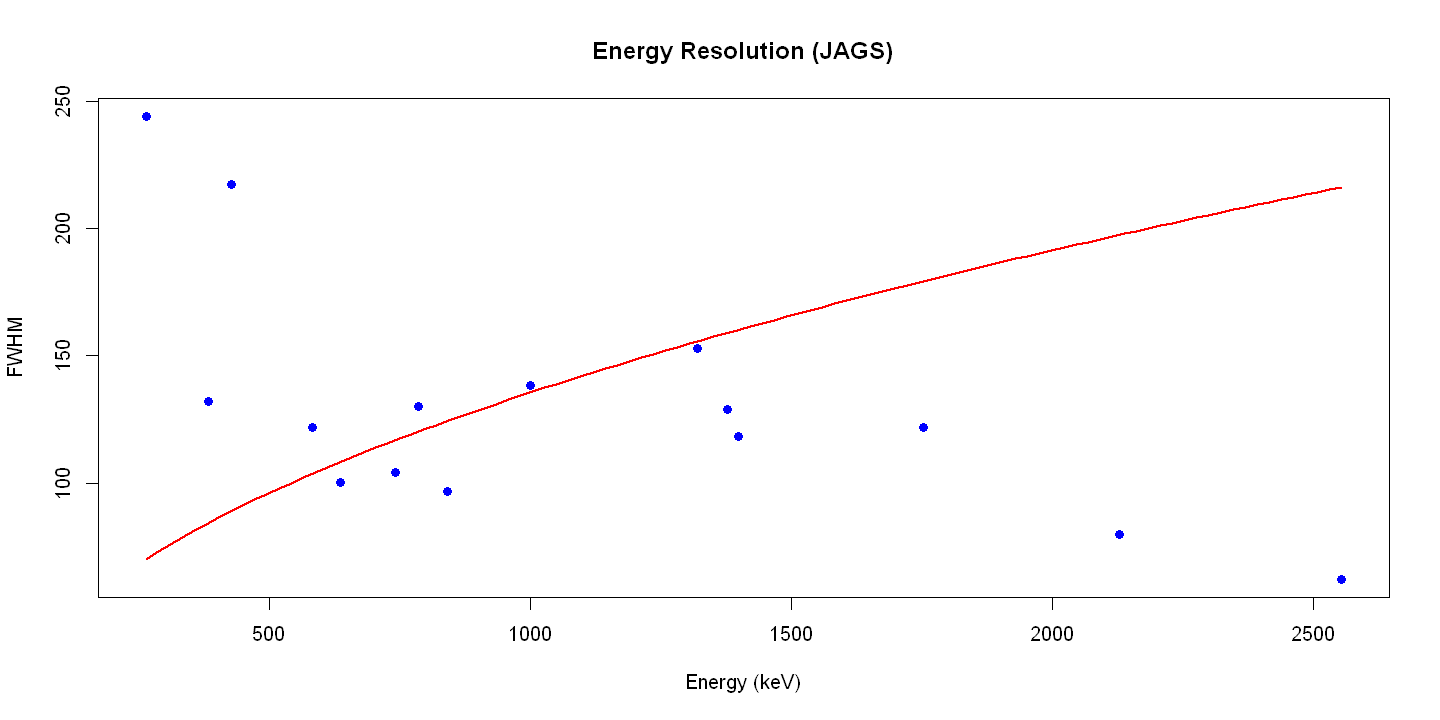

In [21]:
# Extract results from JAGS
results_jags <- as.matrix(jags_samples_Th)

# Get posterior estimates for parameters
F_est_jags <- mean(results_jags[, "F"])
w_est_jags <- mean(results_jags[, "w"])
w_e_est_jags <- mean(results_jags[, "w_e"])

# Print estimated parameters
cat("Estimated parameters (JAGS):\n")
cat("F:", F_est_jags, "\n")
cat("w:", w_est_jags, "\n")
cat("w_e:", w_e_est_jags, "\n")

# Plot the energy resolution function
energy_range_jags <- seq(min(energies_Th), max(energies_Th), length.out = 100)
w_d_jags <- 2 * sqrt(2 * log(2) * F_est_jags * energy_range_jags * w_est_jags)
predicted_fwhm_jags <- sqrt(w_d_jags^2 + w_e_est_jags^2)
plot(energies_Th, fwhm_values_Th, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution (JAGS)")
lines(energy_range_jags, predicted_fwhm_jags, col = "red", lwd = 2)